# Florence-2 Implementation

# 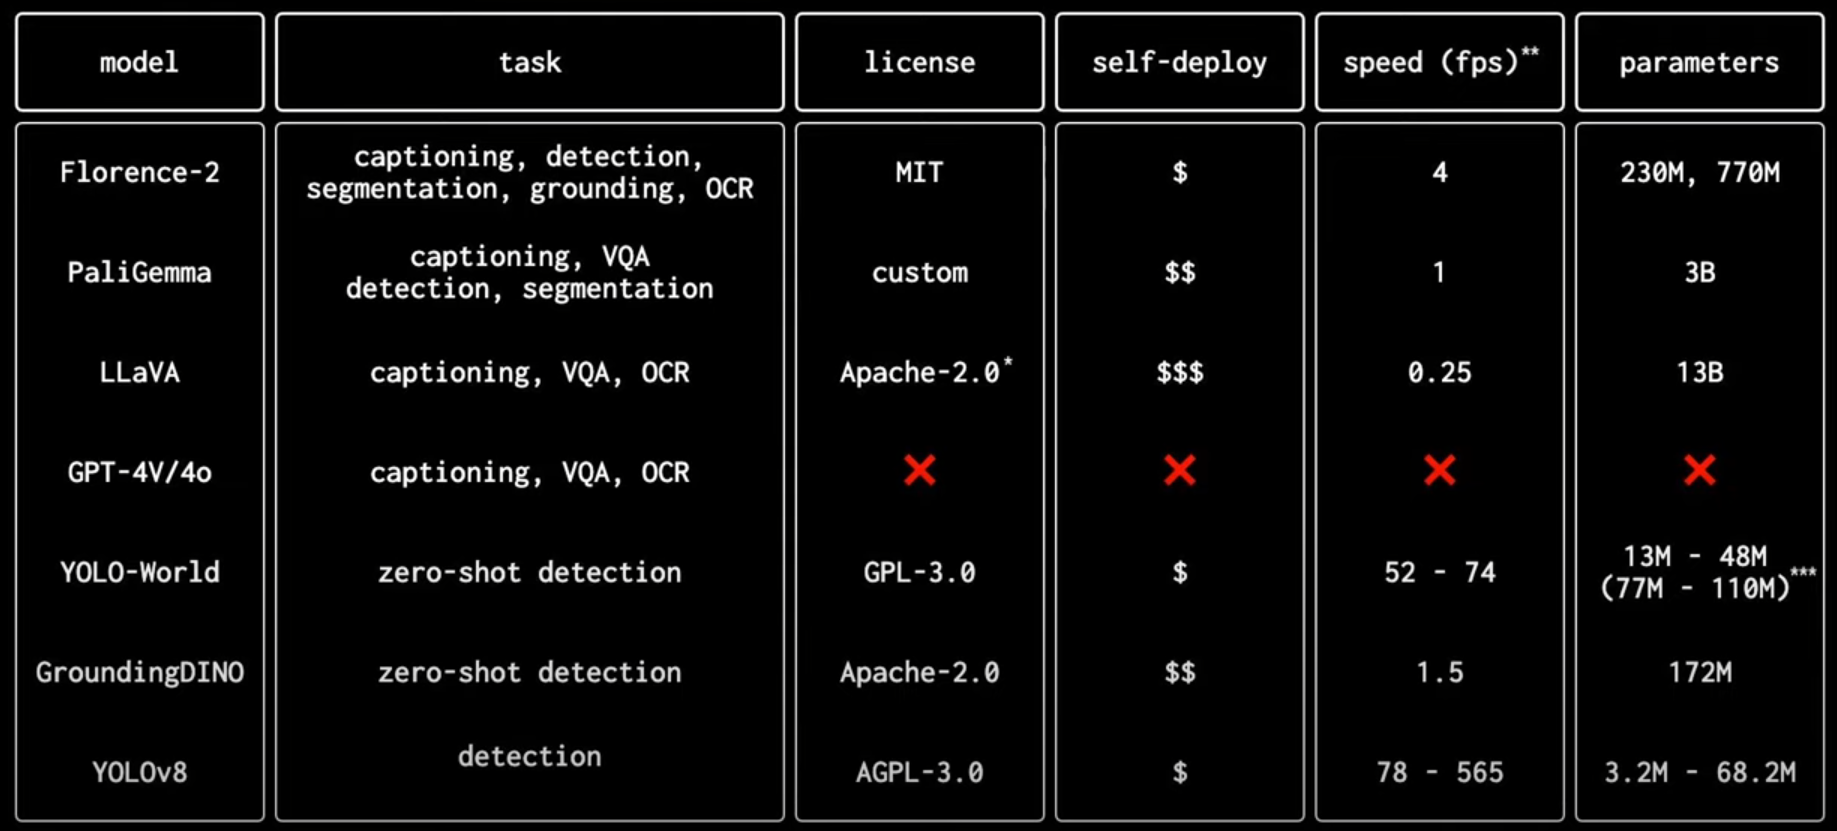

## Setup

In [5]:
EXAMPLE_IMAGE_PATH = "/content/0000076_00352_d_0000002.jpg"

In [62]:
!pip install -q transformers flash_attn timm einops peft
!pip install -q roboflow git+https://github.com/roboflow/supervision.git
!pip install torchvision==0.15.2

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 459.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 945.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 1.7 MB/

## Imports

In [63]:
import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv

import torchvision

from google.colab import userdata
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

In [8]:
#Load the model using AutoModelForCausalLM and the processor using AutoProcessor classes from the transformers library. Note that you need to pass trust_remote_code as True since this model is not a standard transformers mode
CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION)

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884


## Run inference with pre-trained Florence-2 model

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


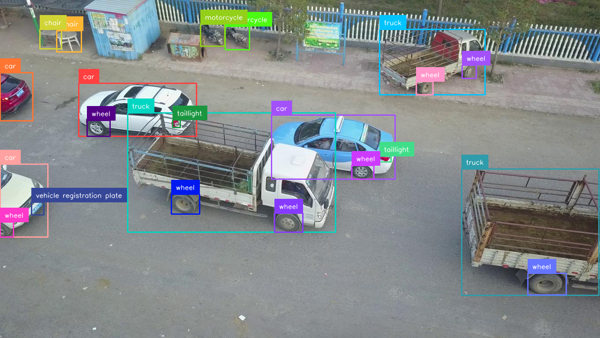

In [9]:
# @title Example object detection inference
image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [12]:
print(type(detections))
print('-'*25)
print(detections)
print('-'*25)
print(detections.data)
print('-'*25)
print(response)
print('-'*25)
print(generated_text)

<class 'supervision.detection.core.Detections'>
-------------------------
Detections(xyxy=array([[6.15400024e+02, 2.60482483e+02, 8.95559998e+02, 4.05067505e+02],
       [1.78839996e+02, 1.88572495e+02, 4.45399994e+02, 3.08677490e+02],
       [6.80000007e-01, 3.71407501e+02, 1.08120003e+02, 5.36647461e+02],
       [6.80000007e-01, 1.64092499e+02, 7.41200027e+01, 2.73487488e+02],
       [1.28520004e+02, 6.92324982e+01, 1.84279999e+02, 1.17427498e+02],
       [9.04400024e+01, 6.69375000e+01, 1.39399994e+02, 1.10542496e+02],
       [5.10679993e+02, 5.92874985e+01, 5.65080017e+02, 1.12072495e+02],
       [4.54920013e+02, 5.46974983e+01, 5.09320007e+02, 1.04422501e+02],
       [8.60200012e+02, 3.53812500e+02, 8.86040039e+02, 3.66817505e+02],
       [3.91000000e+02, 2.71192505e+02, 4.08679993e+02, 2.88787506e+02],
       [2.89000000e+02, 2.55892502e+02, 7.60919983e+02, 5.25937500e+02],
       [1.04652002e+03, 3.82117493e+02, 1.35795996e+03, 6.68227478e+02],
       [8.60200012e+02, 6.61725006

In [17]:
# @title Example image captioning inference

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<DETAILED_CAPTION>"
text = "<DETAILED_CAPTION>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
response

{'<DETAILED_CAPTION>': 'In this image we can see vehicles on the road. In the background there are trees, fence, boards, tables, chairs and other objects.'}

- Detecta la cerca (fence) por mas que no detecto la clase en el ejemplo de las bbox. eso es porque uno le puede especificar que se enfoque en el fondo o que lo ignore como se muestra a continuacion:

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


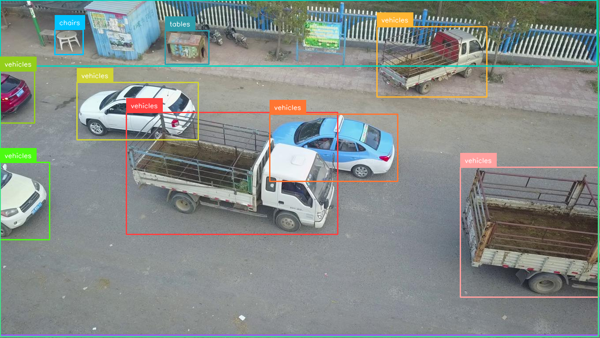

In [26]:
# @title Example image captioning inference

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<CAPTION_TO_PHRASE_GROUNDING>"
text = f"<CAPTION_TO_PHRASE_GROUNDING> In this image we can see vehicles on the road. In the background there are trees, fence, boards, tables, chairs and other objects."

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response2 = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response2, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


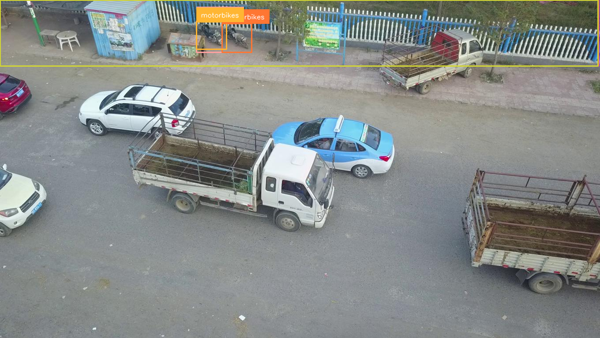

In [27]:
# @title Example image captioning inference focused in the background

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<CAPTION_TO_PHRASE_GROUNDING>"
text = f"<CAPTION_TO_PHRASE_GROUNDING> In the background there are trees, fence, motorbikes and grass."

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response2 = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response2, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [29]:
detections.data

{'class_name': array(['trees', 'fence', 'motorbikes', 'motorbikes', 'motorbikes',
        'grass'], dtype='<U10')}

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


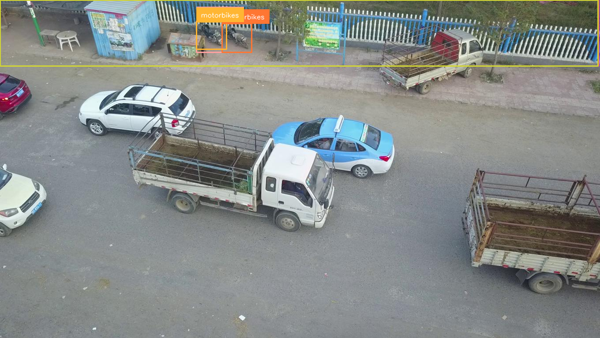

In [30]:
# @title Example OD with captioning

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = f"<CAPTION_TO_PHRASE_GROUNDING> In the background there are trees, fence, motorbikes and grass."

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response2 = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response2, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

---

# Fine tunning for Visdrone

## Yolo Dataset

In [32]:
import gdown
import zipfile
import os

In [66]:
# Descargar el archivo desde Google Drive
file_id_train = '1Vp9yMIzC9cokrEKEoc-B3dmPLWwGTNTw' #https://drive.google.com/file/d/1Vp9yMIzC9cokrEKEoc-B3dmPLWwGTNTw/view?usp=drive_link
gdown.download(f'https://drive.google.com/uc?id={file_id_train}', 'VisDrone2019-DET-train.zip', quiet=False)

# Descomprimir el archivo
with zipfile.ZipFile("VisDrone2019-DET-train.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

# Eliminar el archivo zip después de la extracción
os.remove("VisDrone2019-DET-train.zip")

# Dataset de validation
file_id_val = '1s7Uymmzd0rgncYC07bRP_xG1CN-TL_4Q' # https://drive.google.com/file/d/1s7Uymmzd0rgncYC07bRP_xG1CN-TL_4Q/view?usp=drive_link
gdown.download(f'https://drive.google.com/uc?id={file_id_val}', 'VisDrone2019-DET-val.zip', quiet=False)

# Descomprimir el archivo
with zipfile.ZipFile("VisDrone2019-DET-val.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

# Eliminar el archivo zip después de la extracción
os.remove("VisDrone2019-DET-val.zip")


Downloading...
From (original): https://drive.google.com/uc?id=1Vp9yMIzC9cokrEKEoc-B3dmPLWwGTNTw
From (redirected): https://drive.google.com/uc?id=1Vp9yMIzC9cokrEKEoc-B3dmPLWwGTNTw&confirm=t&uuid=15d0c145-9d9d-41d6-a91b-eadc0defbbb9
To: /content/VisDrone2019-DET-train.zip
100%|██████████| 1.55G/1.55G [00:47<00:00, 32.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1s7Uymmzd0rgncYC07bRP_xG1CN-TL_4Q
From (redirected): https://drive.google.com/uc?id=1s7Uymmzd0rgncYC07bRP_xG1CN-TL_4Q&confirm=t&uuid=3506b648-cdbe-4dd6-aed5-940087bc8abc
To: /content/VisDrone2019-DET-val.zip
100%|██████████| 81.6M/81.6M [00:00<00:00, 207MB/s]


## Tuned Dataset

- Como habiamos preparado nuestro dataset para YOLO, debemos parsearlo al formato que espera Florence-2 el cual es similar a COCO.

In [39]:
import os
from PIL import Image
from torch.utils.data import Dataset
from typing import List, Dict, Any, Tuple

### Class Dataset

In [81]:
class VisDroneDataset:
    def __init__(self, annotations_directory: str, image_directory: str, limit: int = None):
        self.annotations_directory = annotations_directory
        self.image_directory = image_directory
        self.limit = limit  # Atributo para limitar el número de entradas
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        """
        Load entries from the annotations directory.
        Each entry contains the image path and corresponding annotations.
        """
        entries = []
        for idx, annotation_file in enumerate(os.listdir(self.annotations_directory)):
            if self.limit is not None and idx >= self.limit:
                break  # Limitar el número de archivos cargados
            if annotation_file.endswith(".txt"):
                image_id = annotation_file.replace('.txt', '.jpg')
                image_path = os.path.join(self.image_directory, image_id)
                annotation_path = os.path.join(self.annotations_directory, annotation_file)

                if os.path.exists(image_path):
                    annotations = self._parse_annotation_file(annotation_path)
                    entries.append({
                        'image': image_path,
                        'annotations': annotations
                    })
        return entries

    def _parse_annotation_file(self, annotation_file: str) -> List[Dict[str, int]]:
        """
        Parse the VisDrone annotation file and return a list of bounding boxes.
        Each bounding box is represented as a dictionary with x_min, y_min, x_max, y_max.
        """
        boxes = []
        with open(annotation_file, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                x_min, y_min, width, height = map(int, parts[:4])
                x_max = x_min + width
                y_max = y_min + height
                class_id = int(parts[4])  # Assuming class_id is the 5th column

                boxes.append({
                    'class_id': class_id,
                    'x_min': x_min,
                    'y_min': y_min,
                    'x_max': x_max,
                    'y_max': y_max
                })
        return boxes

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, List[Dict[str, int]]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = entry['image']
        annotations = entry['annotations']
        try:
            image = Image.open(image_path)
            return (image, annotations)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, annotations_directory: str, image_directory: str, limit: int = None):
        # Pasar el límite a VisDroneDataset
        self.dataset = VisDroneDataset(annotations_directory, image_directory, limit)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, annotations = self.dataset[idx]
        return image, annotations


In [88]:
# Example usage:
annotations_train = '/content/VisDrone2019-DET-train/annotations'
images_train = '/content/VisDrone2019-DET-train/images'
annotations_val = '/content/VisDrone2019-DET-val/annotations'
images_val = '/content/VisDrone2019-DET-val/images'

dataset_train = DetectionDataset(annotations_train, images_train, limit=2)
dataset_val = DetectionDataset(annotations_val, images_val, limit=4)

# Example: accessing an image and its annotations
image, annotations = dataset_train[1]
print(f"Image size: {image.size}")
print("Annotations:", annotations)

Image size: (2000, 1500)
Annotations: [{'class_id': 1, 'x_min': 1092, 'y_min': 633, 'x_max': 1217, 'y_max': 684}, {'class_id': 1, 'x_min': 938, 'y_min': 621, 'x_max': 1059, 'y_max': 678}, {'class_id': 1, 'x_min': 774, 'y_min': 613, 'x_max': 896, 'y_max': 668}, {'class_id': 1, 'x_min': 1413, 'y_min': 647, 'x_max': 1551, 'y_max': 700}, {'class_id': 1, 'x_min': 1550, 'y_min': 627, 'x_max': 1638, 'y_max': 681}, {'class_id': 1, 'x_min': 1622, 'y_min': 447, 'x_max': 1707, 'y_max': 481}, {'class_id': 1, 'x_min': 1552, 'y_min': 397, 'x_max': 1601, 'y_max': 422}, {'class_id': 1, 'x_min': 1657, 'y_min': 348, 'x_max': 1706, 'y_max': 368}, {'class_id': 1, 'x_min': 369, 'y_min': 606, 'x_max': 482, 'y_max': 652}, {'class_id': 1, 'x_min': 105, 'y_min': 595, 'x_max': 216, 'y_max': 641}, {'class_id': 1, 'x_min': 785, 'y_min': 420, 'x_max': 850, 'y_max': 448}, {'class_id': 1, 'x_min': 961, 'y_min': 363, 'x_max': 1009, 'y_max': 381}, {'class_id': 1, 'x_min': 0, 'y_min': 663, 'x_max': 60, 'y_max': 717}, {

In [89]:
# @title Initiate `DetectionsDataset` and `DataLoader` for train and validation subsets

BATCH_SIZE = 3
NUM_WORKERS = 0
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Función para manejar la agrupación de lotes (batch)
def collate_fn(batch):
    images, annotations = zip(*batch)  # Extraer imágenes y anotaciones de cada lote
    # Aquí puedes hacer el procesamiento necesario para las anotaciones o las imágenes
    # Si usas un procesador (como un transformador para las imágenes), aplícalo aquí:
    images = torch.stack([torchvision.transforms.ToTensor()(img) for img in images]).to(DEVICE)
    return images, annotations

# Inicializar el dataset de entrenamiento y validación usando VisDrone
train_dataset = DetectionDataset(
    annotations_directory='/content/VisDrone2019-DET-train/annotations',
    image_directory='/content/VisDrone2019-DET-train/images',
    limit=300
)
val_dataset = DetectionDataset(
    annotations_directory='/content/VisDrone2019-DET-val/annotations',
    image_directory='/content/VisDrone2019-DET-val/images',
    limit=40
)

# Cargar los datasets usando DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [90]:
# @title Setup LoRA Florence-2 model

config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076


In [91]:
torch.cuda.empty_cache()

## Visualizing the training

Some HTML printable code for visualizing how the model learn through the epochs.

In [92]:
# @title Run inference with pre-trained Florence-2 model on validation dataset

def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline html."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
        image = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
    except:
        print('failed to redner model response')
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(128, 128))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(response))}</p>
</div>
"""
def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        # Check if 'data' is a dictionary and has the key 'prefix'
        if isinstance(data, dict) and 'prefix' in data:
            prefix = data['prefix']
        # If data is not a dictionary, assume prefix is an empty string
        else:
            prefix = ""

        # similar check for suffix if it's used later
        if isinstance(data, dict) and 'suffix' in data:
            suffix = data['suffix']
        else:
            suffix = ""

        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        html_out += render_example(image, answer)

    display(HTML(html_out))

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



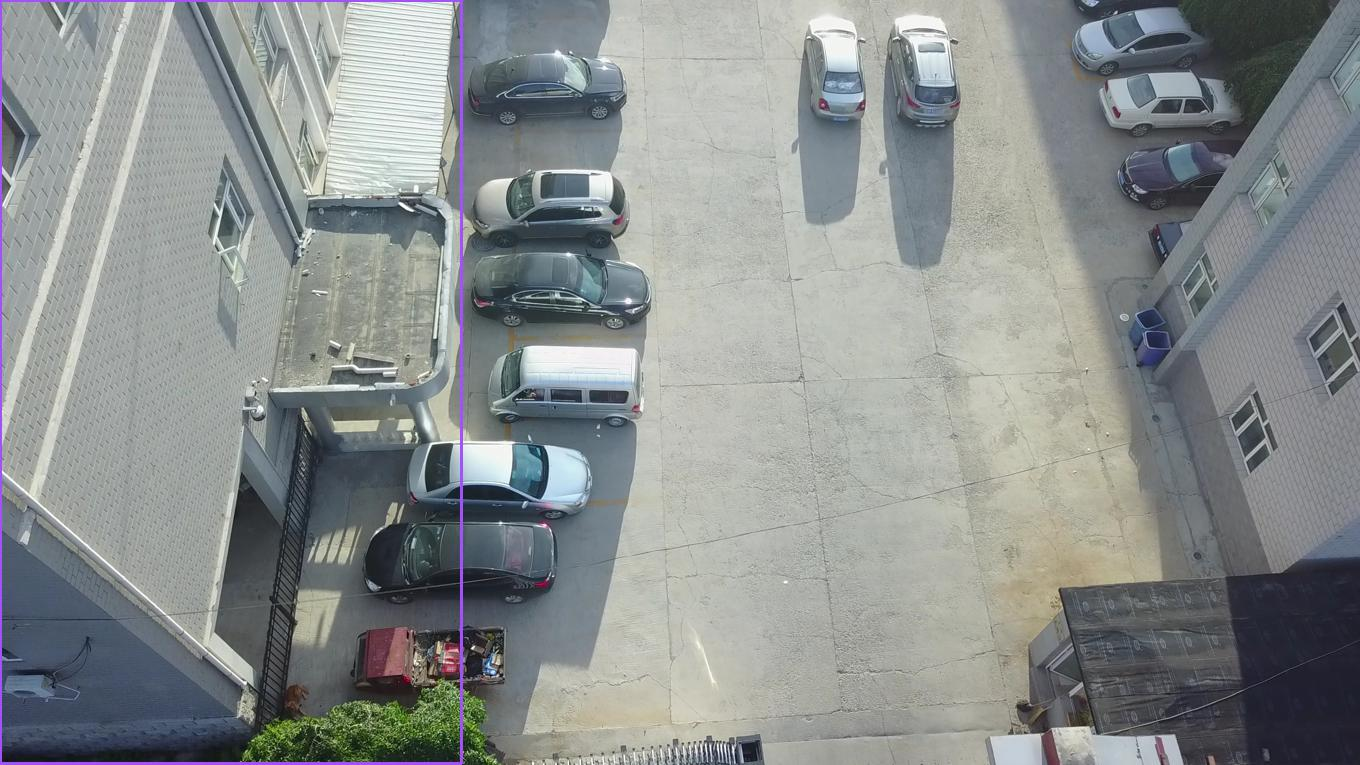

In [93]:
render_inference_results(peft_model, val_dataset, 1)

In [94]:
import base64
import io
import json
from PIL import Image
from IPython.display import display, HTML
import torch

def render_inference_results_v2(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        # Obtener la imagen y sus anotaciones
        image, annotations = dataset.dataset[i]

        # Generar un texto genérico (input_ids)
        prefix = "<OD>"  # Texto genérico que representa Object Detection
        inputs = processor(text=[prefix], images=image, return_tensors="pt").to(DEVICE)

        # Generar la predicción con el modelo
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],  # Ahora incluimos el input_ids generado
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

        # Procesar la salida generada
        answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        html_out += render_example(image, answer)

    display(HTML(html_out))

# Llamada al modelo de inferencia con el dataset de validación
#render_inference_results_v2(peft_model, val_dataset, 4)


# Train

In [69]:
# @title Define train loop

def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    render_inference_results_v2(peft_model, val_loader.dataset, 6)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            #images = [img.resize((512, 512)) for img in inputs["images"]] # Resize images before creating inputs if run out of mem
            #inputs = processor(text=inputs["text"], images=images, return_tensors="pt", padding=True).to(DEVICE)

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                #images = [img.resize((512, 512)) for img in inputs["images"]] # Resize images before creating inputs if run out of mem
                #inputs = processor(text=inputs["text"], images=images, return_tensors="pt", padding=True).to(DEVICE)
                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            render_inference_results_v2(peft_model, val_loader.dataset, 6)

        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to 


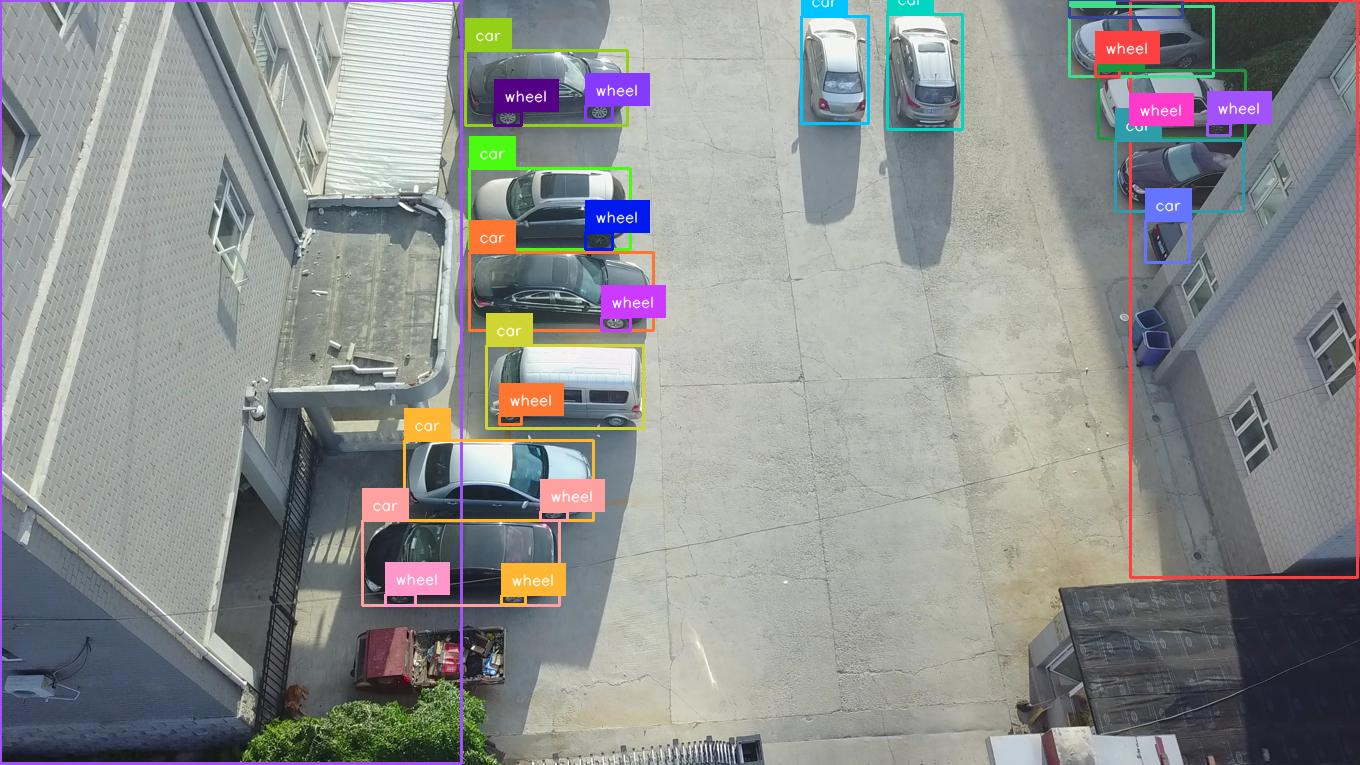
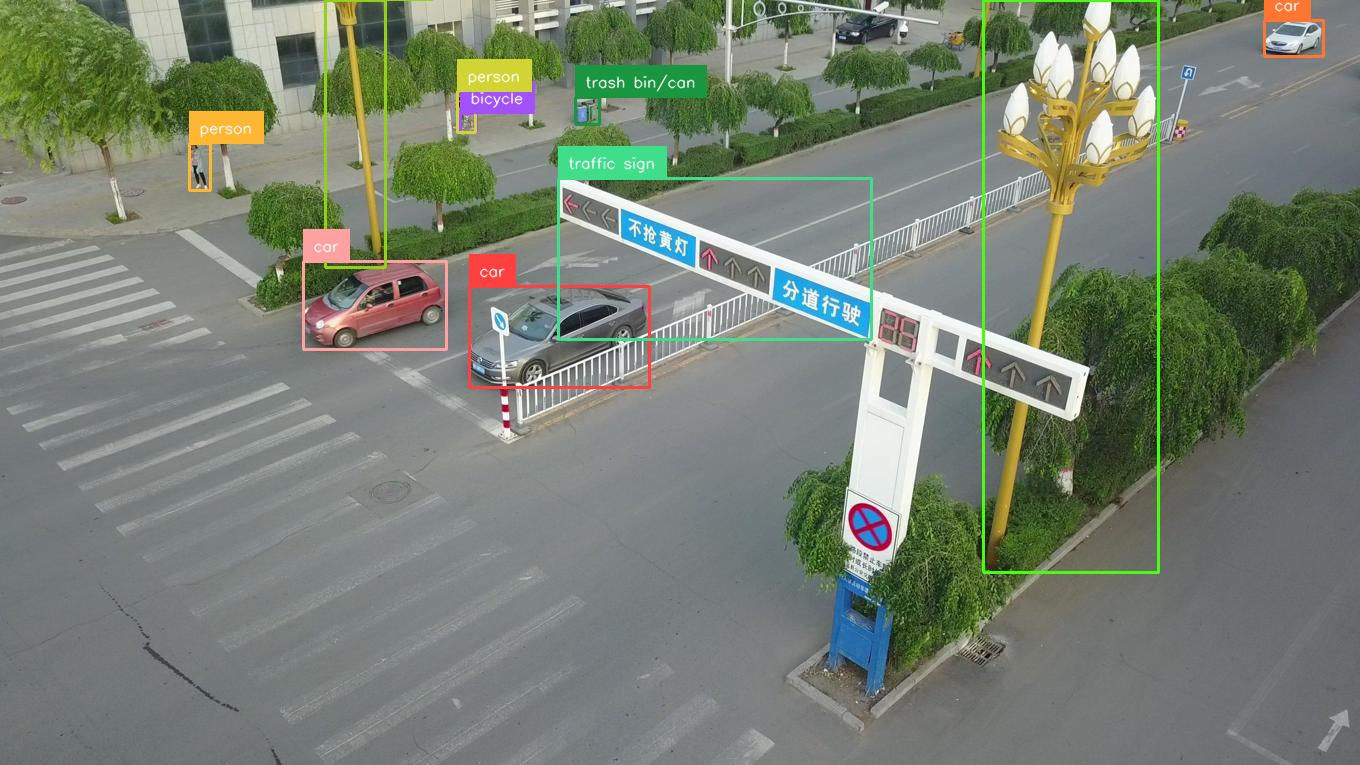
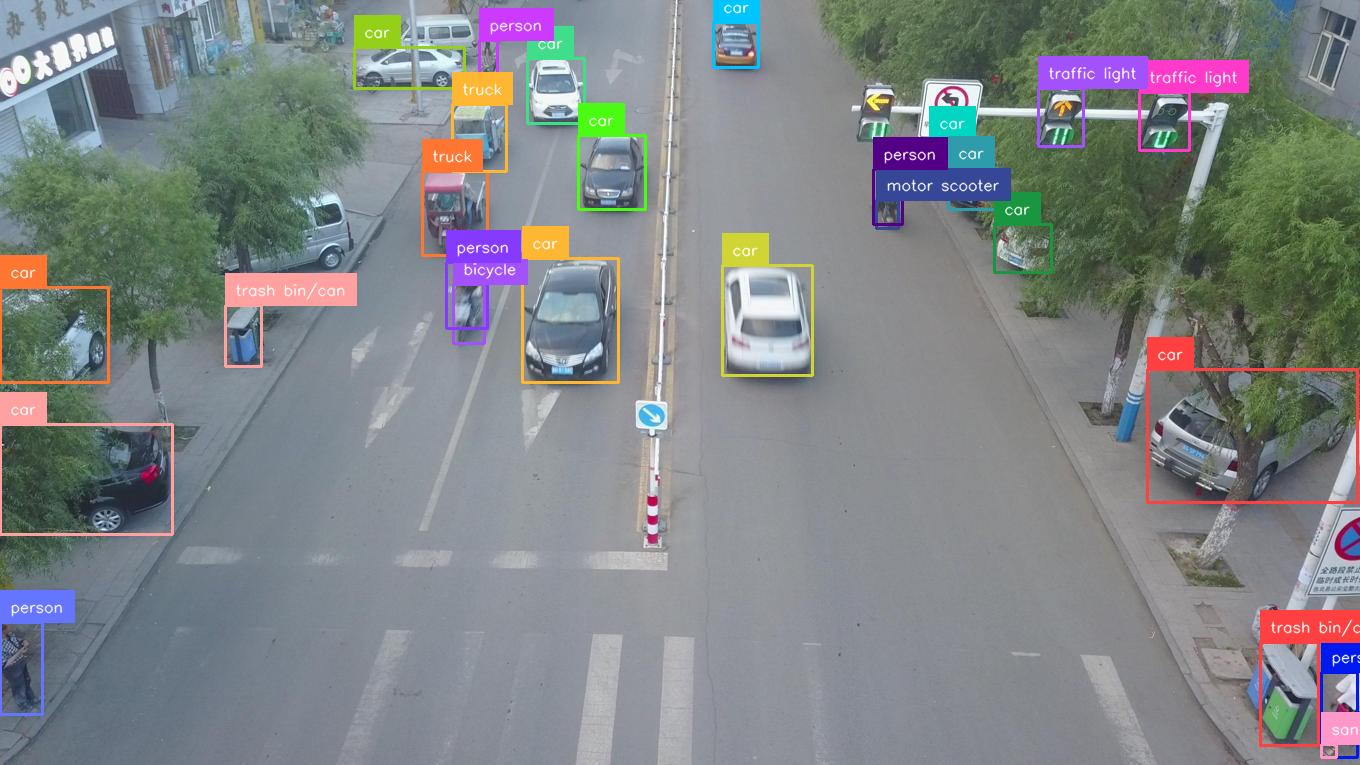
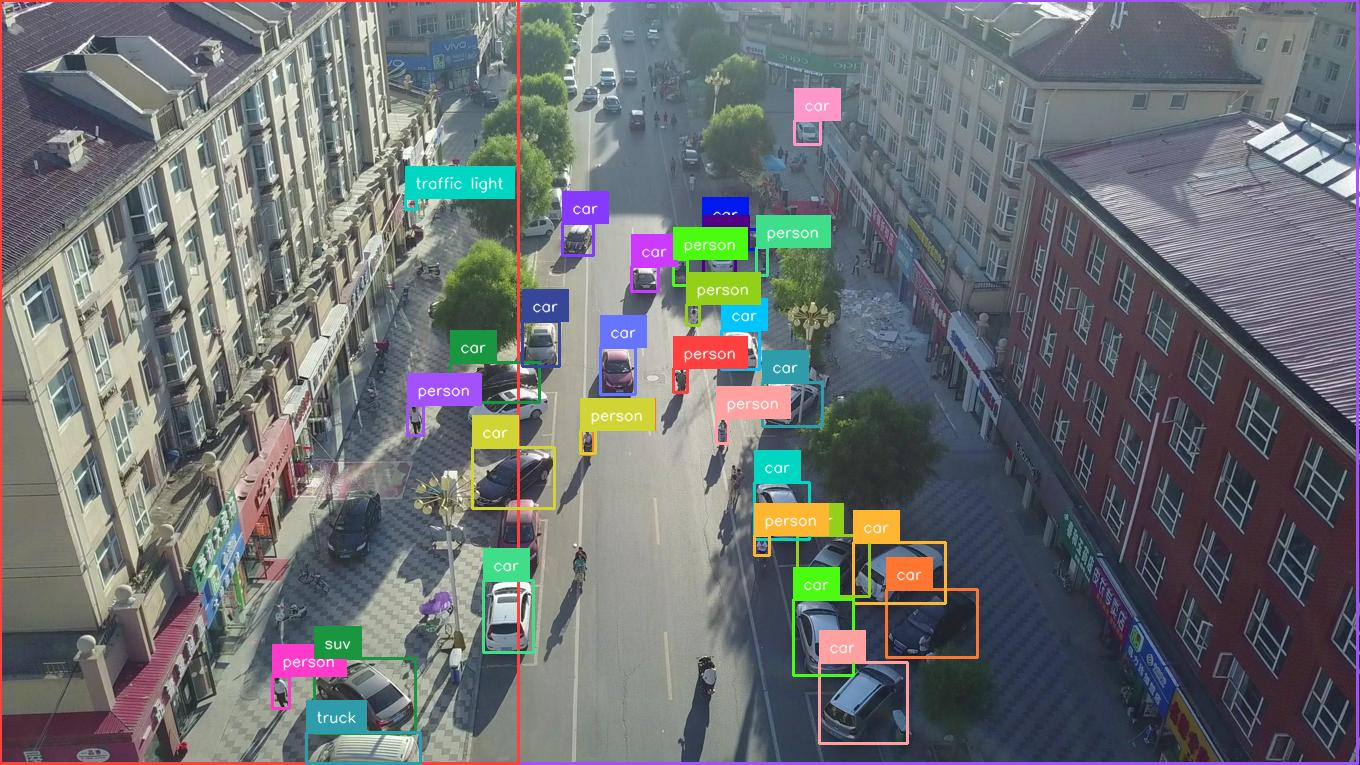
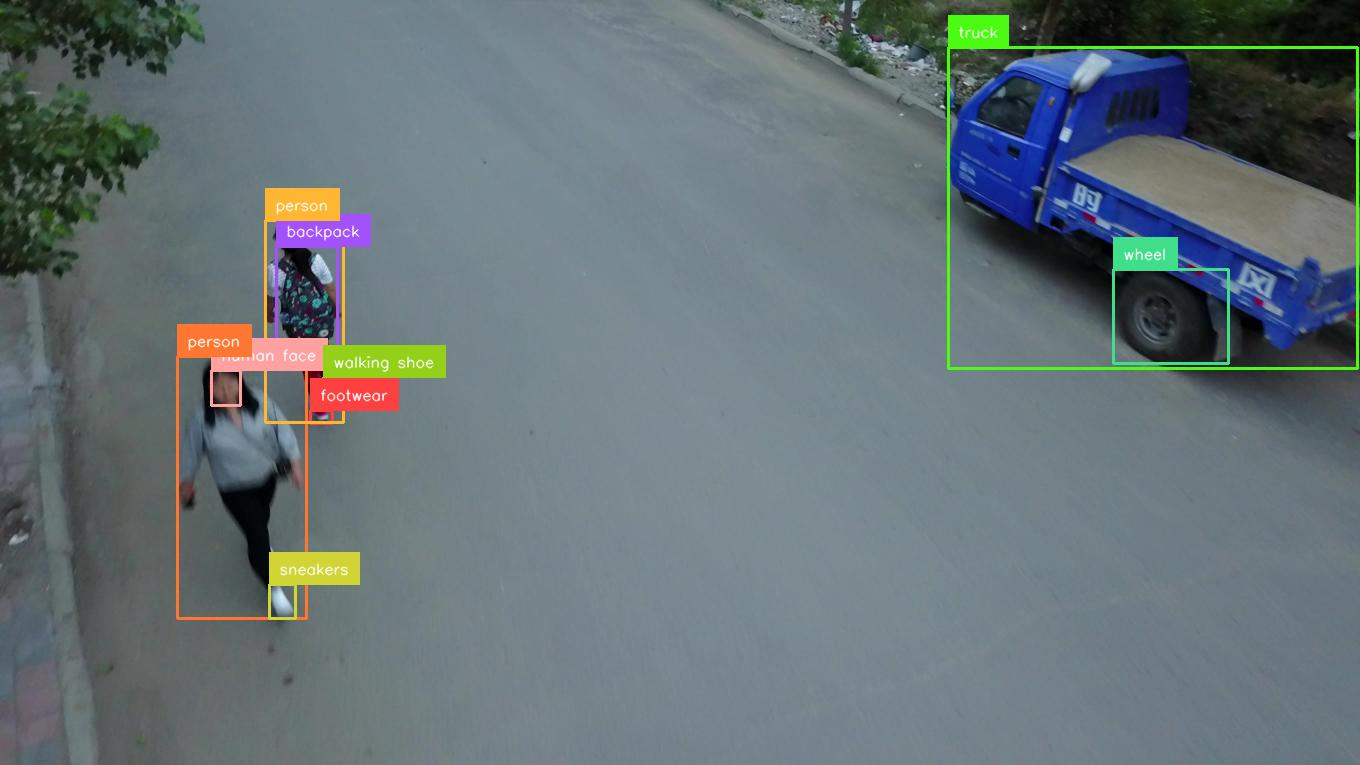
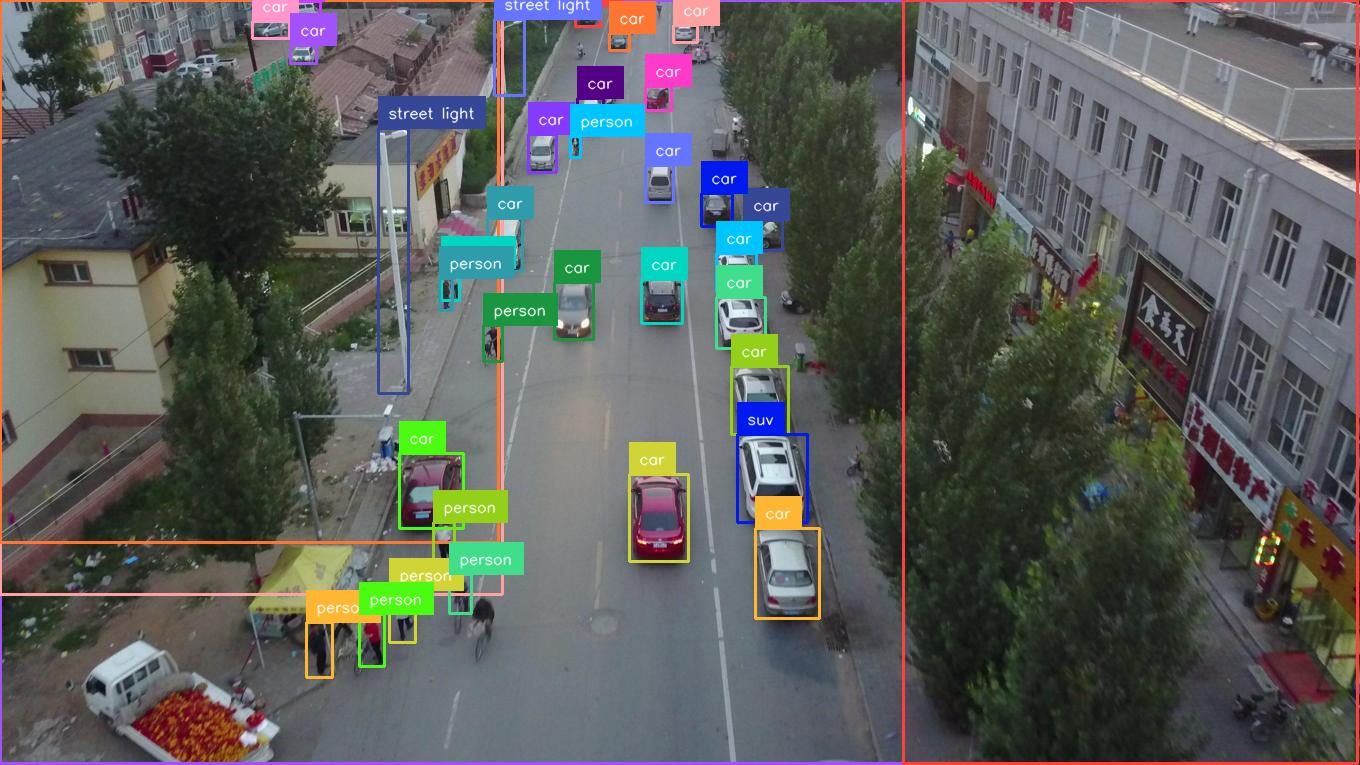

Training Epoch 1/5:   0%|          | 0/100 [00:00<?, ?it/s]


IndexError: too many indices for tensor of dimension 4

In [95]:
# @title Run train loop

%%time

EPOCHS = 5
LR = 5e-6

train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)